In [2]:
from pprint import pprint
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from comparers import ModelComparer
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, get_pruned_trees, eval_diro2c
from surrogate_tree import get_feature_importances, plot_feature_importances, plot_surrogate_tree,\
                           extract_rules, print_rules, plot_tree_leafs_for_class,\
                           group_metrics

In [3]:
with open('task.pickle', 'rb') as f:
    clf_a, clf_b, X, y, feature_names, feature_precisions = pickle.load(f)

In [4]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [5]:
mclass_diff = comparer.predict_mclass_diff(X)

# Explanations

In [6]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    explainer = WrappedDiro2C(X, comparer, class_name)
    explanation = explainer.generate_global_explanation()
    with open(f'diro2c.{class_name}.pickle', 'wb') as f:
        pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

(0, 0)
(0, 1)
(1, 0)
(1, 1)
CPU times: user 28min 6s, sys: 6.1 s, total: 28min 12s
Wall time: 28min 32s


## $(0,1)$

In [5]:
focus_class = '(0, 1)'
y_true = comparer.class_names[mclass_diff] == focus_class

In [6]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [7]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 101 ms, sys: 4.31 ms, total: 106 ms
Wall time: 111 ms


6

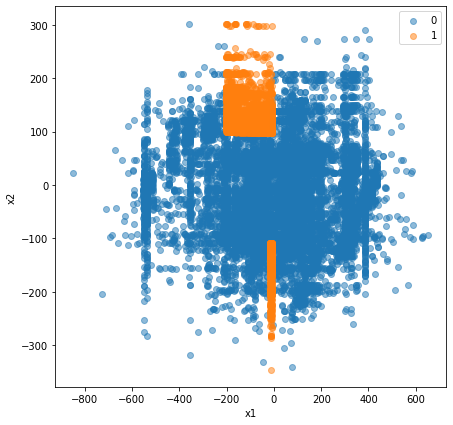

In [8]:
plot_diro2c_2d(explanation, 'x1', 'x2')

### 2 Leafs

In [9]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.05473425089743424, 1, 2)

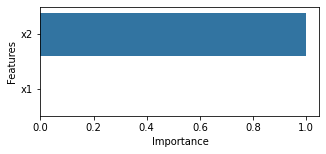

In [10]:
feature_importances, feature_order = get_feature_importances(tree)
plot_feature_importances(feature_names, feature_importances, feature_order)

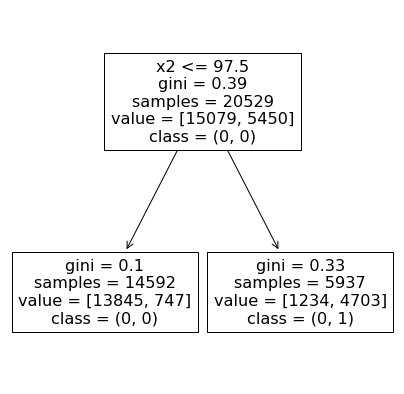

In [11]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [12]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x2 > 97.49974060058594 => (0, 1) [1234, 4703]


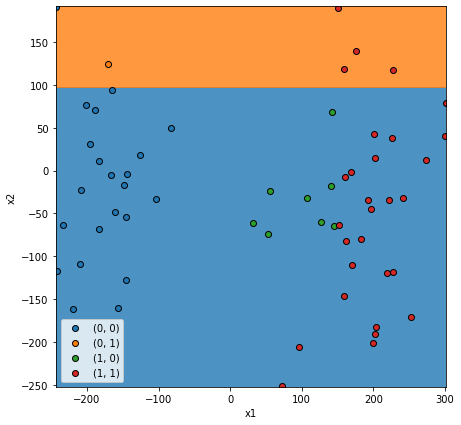

In [13]:
plot_tree_leafs_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names)

### 3 Leafs

In [14]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.04049827214582135, 2, 3)

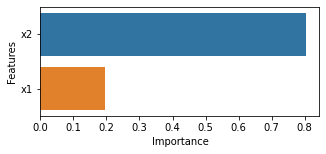

In [15]:
feature_importances, feature_order = get_feature_importances(tree)
plot_feature_importances(feature_names, feature_importances, feature_order)

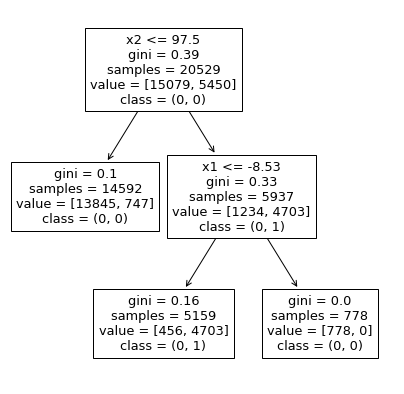

In [16]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [17]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= -8.529430389404297 and x2 > 97.49974060058594 => (0, 1) [456, 4703]


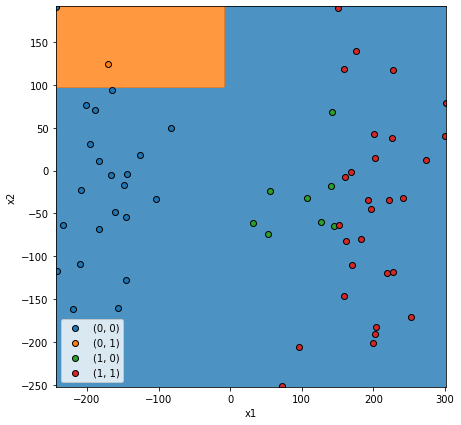

In [18]:
plot_tree_leafs_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names)

### 4 Leafs

In [19]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.022206397087607476, 3, 4)

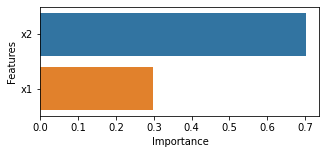

In [20]:
feature_importances, feature_order = get_feature_importances(tree)
plot_feature_importances(feature_names, feature_importances, feature_order)

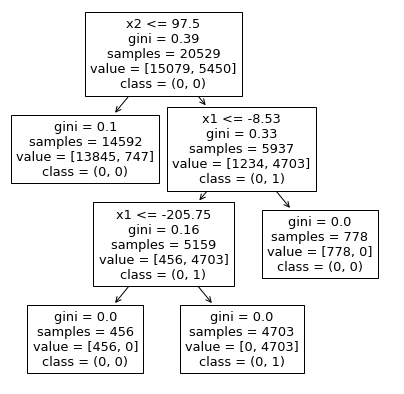

In [21]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [22]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -205.74828338623047 < x1 <= -8.529430389404297 and x2 > 97.49974060058594 => (0, 1) [0, 4703]


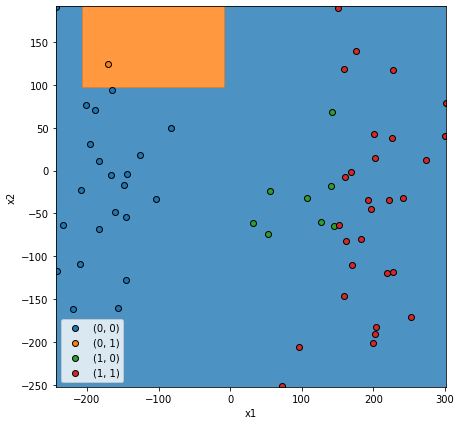

In [23]:
plot_tree_leafs_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names)

### 7 Leafs

In [24]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0005872967410532174, 4, 7)

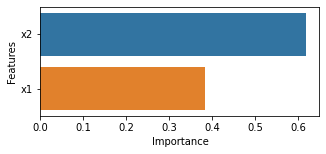

In [25]:
feature_importances, feature_order = get_feature_importances(tree)
plot_feature_importances(feature_names, feature_importances, feature_order)

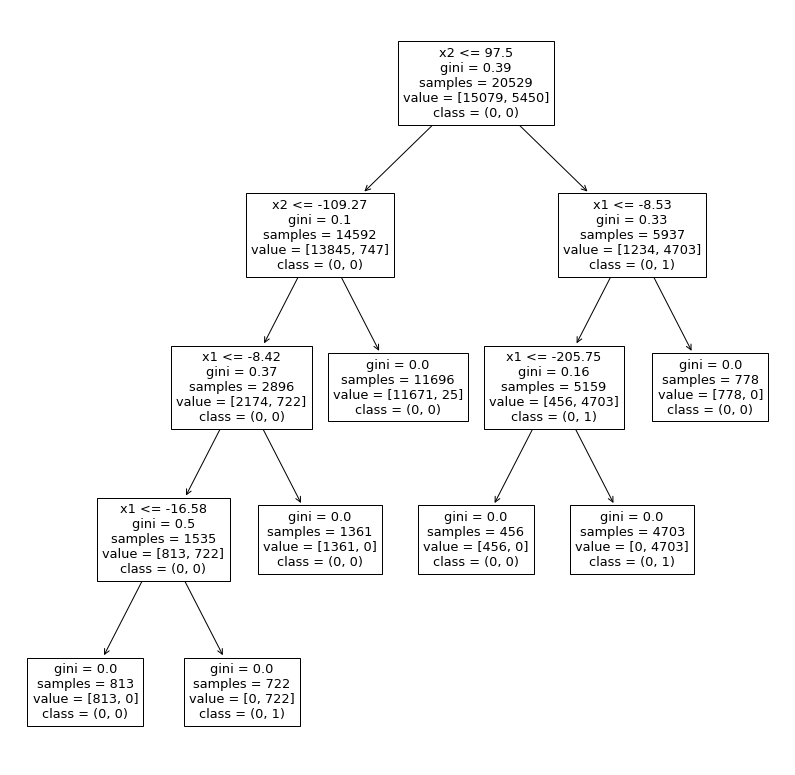

In [26]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(14, 14))

In [27]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -205.74828338623047 < x1 <= -8.529430389404297 and x2 > 97.49974060058594 => (0, 1) [0, 4703]
2. -16.578688621520996 < x1 <= -8.42380666732788 and x2 <= -109.26507949829102 => (0, 1) [0, 722]


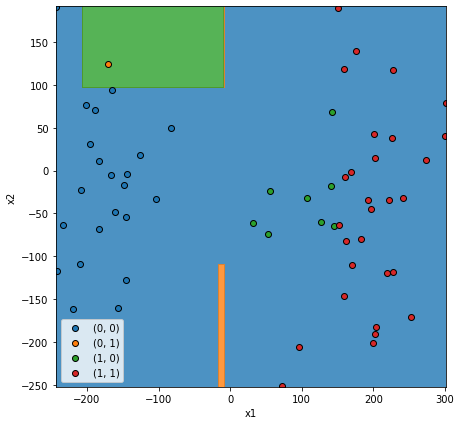

In [28]:
plot_tree_leafs_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names)

### 11 Leafs

In [29]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(8.118596457044507e-05, 6, 11)

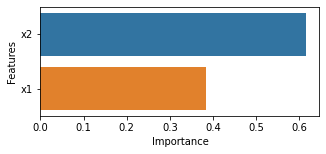

In [30]:
feature_importances, feature_order = get_feature_importances(tree)
plot_feature_importances(feature_names, feature_importances, feature_order)

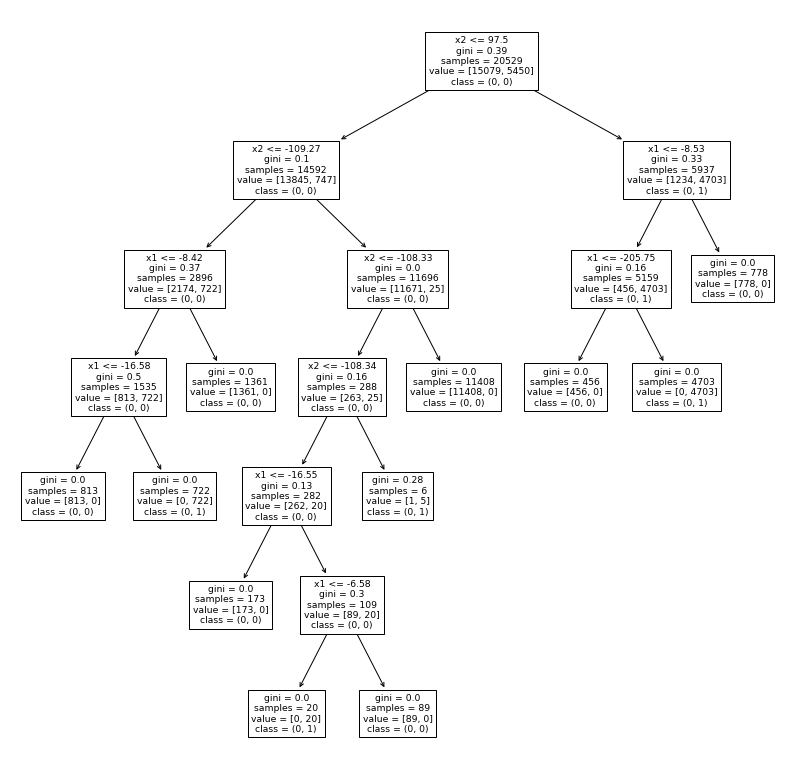

In [31]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(14, 14))

In [32]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -205.74828338623047 < x1 <= -8.529430389404297 and x2 > 97.49974060058594 => (0, 1) [0, 4703]
2. -16.578688621520996 < x1 <= -8.42380666732788 and x2 <= -109.26507949829102 => (0, 1) [0, 722]
3. -16.554166793823242 < x1 <= -6.578253507614136 and -109.26507949829102 < x2 <= -108.3367691040039 => (0, 1) [0, 20]
4. -108.3367691040039 < x2 <= -108.3252944946289 => (0, 1) [1, 5]


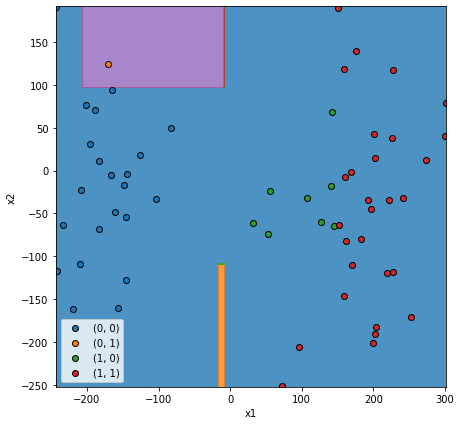

In [33]:
plot_tree_leafs_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names)

### 12 Leafs

In [34]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0, 6, 12)

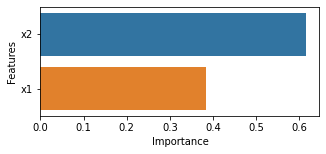

In [35]:
feature_importances, feature_order = get_feature_importances(tree)
plot_feature_importances(feature_names, feature_importances, feature_order)

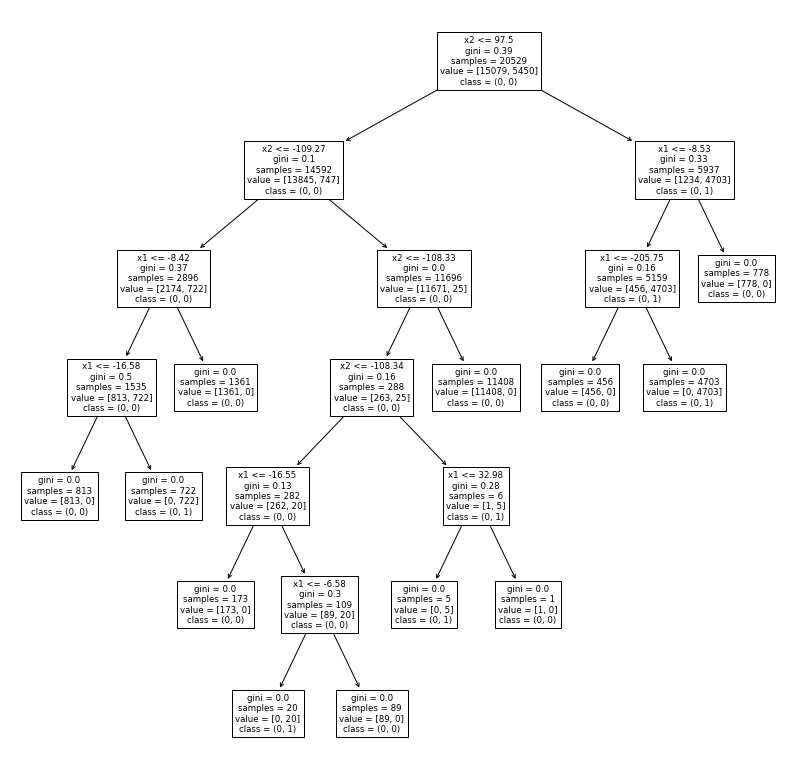

In [36]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(14, 14))

In [37]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -205.74828338623047 < x1 <= -8.529430389404297 and x2 > 97.49974060058594 => (0, 1) [0, 4703]
2. -16.578688621520996 < x1 <= -8.42380666732788 and x2 <= -109.26507949829102 => (0, 1) [0, 722]
3. -16.554166793823242 < x1 <= -6.578253507614136 and -109.26507949829102 < x2 <= -108.3367691040039 => (0, 1) [0, 20]
4. x1 <= 32.98036766052246 and -108.3367691040039 < x2 <= -108.3252944946289 => (0, 1) [0, 5]


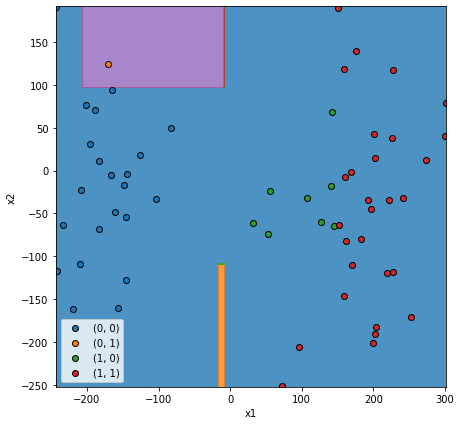

In [38]:
plot_tree_leafs_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names)

## $(1,0)$

In [39]:
focus_class = '(1, 0)'
y_true = comparer.class_names[mclass_diff] == focus_class

In [40]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [41]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 112 ms, sys: 10.7 ms, total: 122 ms
Wall time: 131 ms


4

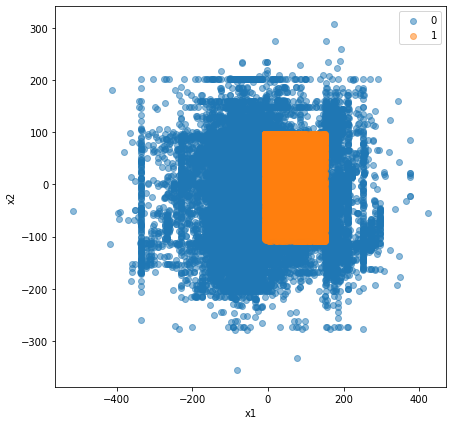

In [42]:
plot_diro2c_2d(explanation, 'x1', 'x2')

### 2 Leafs

In [43]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.12928496598177025, 1, 2)

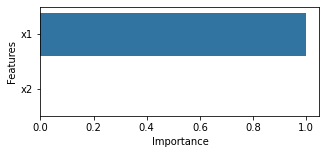

In [44]:
feature_importances, feature_order = get_feature_importances(tree)
plot_feature_importances(feature_names, feature_importances, feature_order)

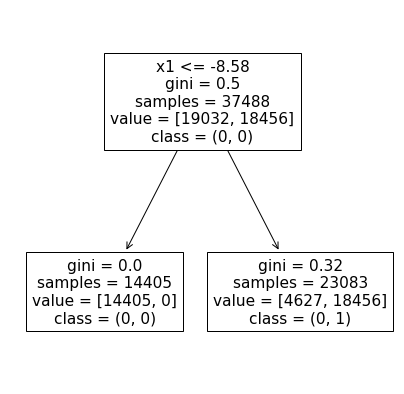

In [45]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [46]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > -8.581614971160889 => (0, 1) [4627, 18456]


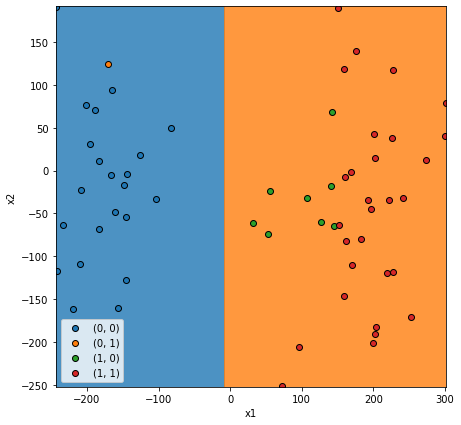

In [47]:
plot_tree_leafs_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names)

### 3 Leafs

In [48]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.04297459599610041, 2, 3)

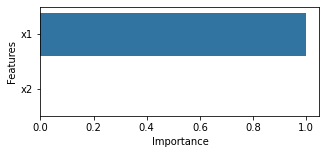

In [49]:
feature_importances, feature_order = get_feature_importances(tree)
plot_feature_importances(feature_names, feature_importances, feature_order)

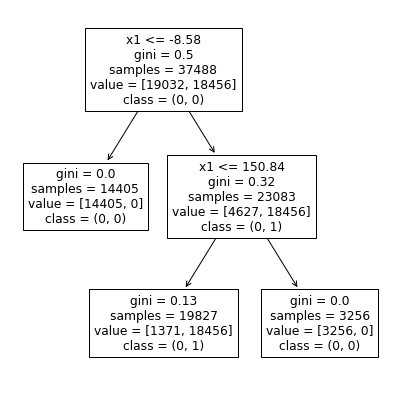

In [50]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [51]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -8.581614971160889 < x1 <= 150.83705139160156 => (0, 1) [1371, 18456]


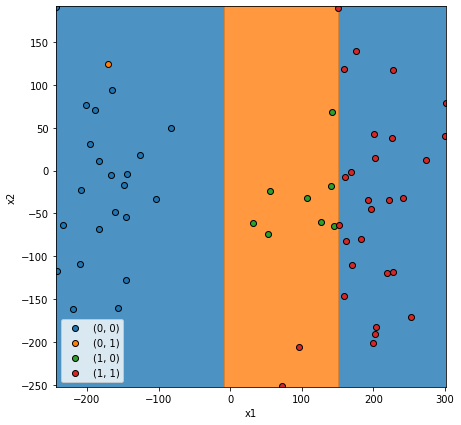

In [52]:
plot_tree_leafs_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names)

### 4 Leafs

In [53]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.025111080056944075, 3, 4)

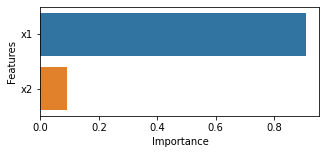

In [54]:
feature_importances, feature_order = get_feature_importances(tree)
plot_feature_importances(feature_names, feature_importances, feature_order)

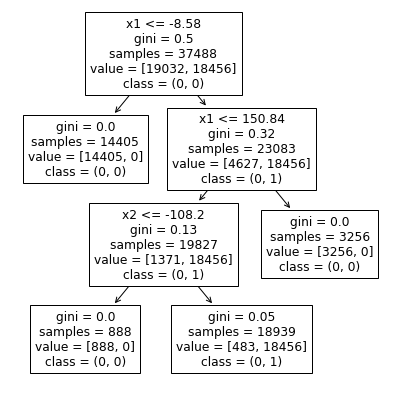

In [55]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [56]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -8.581614971160889 < x1 <= 150.83705139160156 and x2 > -108.20000076293945 => (0, 1) [483, 18456]


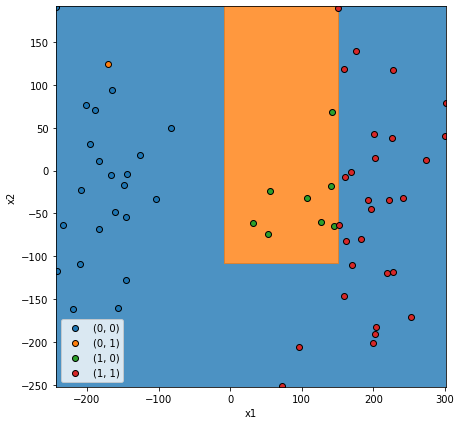

In [57]:
plot_tree_leafs_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names)

### 4 Leafs

In [58]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0, 4, 5)

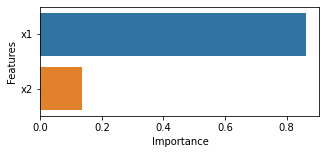

In [59]:
feature_importances, feature_order = get_feature_importances(tree)
plot_feature_importances(feature_names, feature_importances, feature_order)

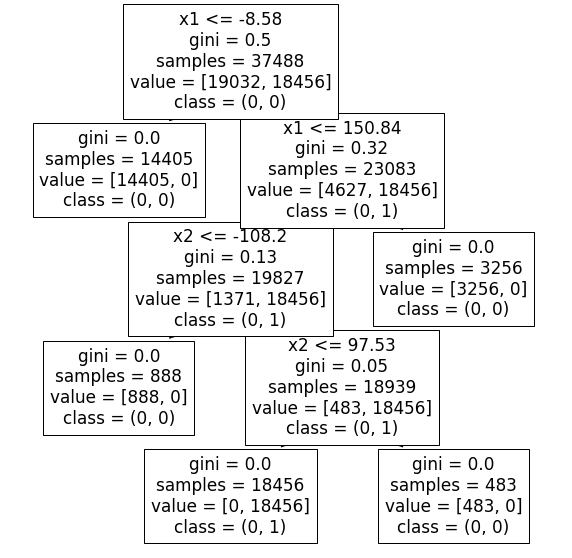

In [63]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(10, 10))

In [64]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -8.581614971160889 < x1 <= 150.83705139160156 and -108.20000076293945 < x2 <= 97.52699279785156 => (0, 1) [0, 18456]


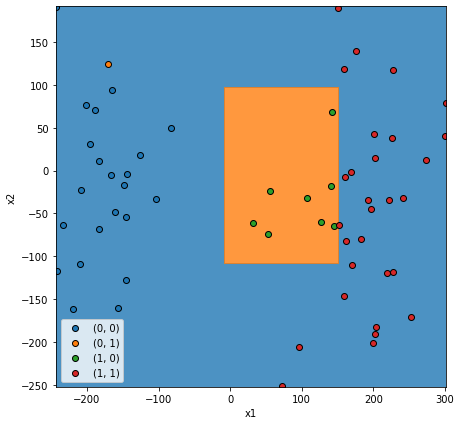

In [65]:
plot_tree_leafs_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names)

# Evaluation

In [6]:
with open('test.pickle', 'rb') as f:
    X_test, y_test = pickle.load(f)

In [7]:
explanations_per_class = {}
for class_name in comparer.class_names:
    with open(f'diro2c.{class_name}.pickle', 'rb') as f:
        explanations_per_class[class_name] = pickle.load(f)

In [8]:
metrics = eval_diro2c(explanations_per_class, X_test, y_test, comparer.class_names)
metrics

,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
1,0.859787,0.997778,0.923657,4050.0,"(0, 0)",2.0,0.073062,1.0,1.0
1,0.980713,0.991852,0.986251,4050.0,"(0, 0)",3.0,0.017967,1.0,2.0
1,0.980825,0.997778,0.989229,4050.0,"(0, 0)",4.0,0.005746,2.0,4.0
1,0.989713,0.997778,0.993729,4050.0,"(0, 0)",6.0,0.000899,3.0,8.0
1,1.000000,0.997778,0.998888,4050.0,"(0, 0)",8.0,0.000053,4.0,11.0
1,0.999753,0.999259,0.999506,4050.0,"(0, 0)",11.0,0.000053,5.0,15.0
1,0.999753,0.999259,0.999506,4050.0,"(0, 0)",12.0,0.000000,5.0,15.0
1,0.446275,0.942511,0.605737,661.0,"(0, 1)",2.0,0.054734,1.0,1.0
1,0.958462,0.942511,0.950420,661.0,"(0, 1)",3.0,0.040498,1.0,2.0
1,0.995208,0.942511,0.968143,661.0,"(0, 1)",4.0,0.022206,1.0,3.0


In [9]:
grouped_metrics, constraints = group_metrics(metrics, by='Alpha')

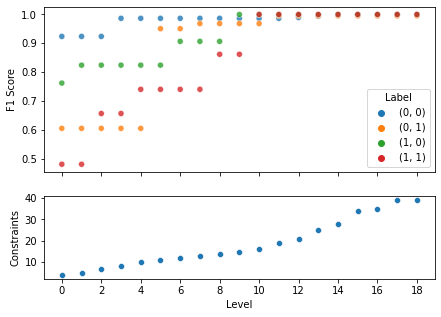

In [10]:
fig, axs = plt.subplots(nrows=2, figsize=(7, 5), sharex='all', gridspec_kw={'height_ratios': [2,1]})
sns.scatterplot(data=grouped_metrics, x='Level', y='F1 Score', hue='Label', alpha=0.8, ax=axs[0])
sns.scatterplot(data=constraints, ax=axs[1])
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('running-diro2c-fidelity.pdf')

In [11]:
grouped_metrics

Label  Precision    Recall  F1 Score  Support  Leafs     Alpha  \
Level                                                                      
0     0  (0, 0)   0.859787  0.997778  0.923657   4050.0    2.0  0.073062   
      1  (0, 1)   0.446275  0.942511  0.605737    661.0    2.0  0.054734   
      2  (1, 0)   0.615952  1.000000  0.762339   3259.0    2.0  0.129285   
      3  (1, 1)   1.000000  0.317241  0.481675   2030.0    2.0  0.079882   
1     0  (0, 0)   0.859787  0.997778  0.923657   4050.0    2.0  0.073062   
...         ...        ...       ...       ...      ...    ...       ...   
17    3  (1, 1)   0.999507  0.999507  0.999507   2030.0    6.0  0.000000   
18    0  (0, 0)   0.999753  0.999259  0.999506   4050.0   12.0  0.000000   
      1  (0, 1)   0.989521  1.000000  0.994733    661.0   12.0  0.000000   
      2  (1, 0)   0.998774  1.000000  0.999387   3259.0    5.0  0.000000   
      3  (1, 1)   0.999507  0.999507  0.999507   2030.0    6.0  0.000000   

         Rules  Constraints  
Level                        
0     0    1.0          1.0  
      1    1.0          1.0  
      2    1.0          1.0  
      3    1.0          1.0  
1     0    1.0          1.0  
...        ...          ...  
17    3    3.0          7.0  
18    0    5.0         15.0  
      1    4.0         13.0  
      2    1.0          4.0  
      3    3.0          7.0  

[76 rows x 9 columns]

In [12]:
constraints

Level
0      4.0
1      5.0
2      7.0
3      8.0
4     10.0
5     11.0
6     12.0
7     13.0
8     14.0
9     15.0
10    16.0
11    19.0
12    21.0
13    25.0
14    28.0
15    34.0
16    35.0
17    39.0
18    39.0
Name: Constraints, dtype: float64